In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## PART 1: SETTING UP THE ENVIRONMENT ##
🧹 Cleaning up previous runs for a fresh start...
🚀 Cloning all necessary repositories...
📦 Installing all dependencies...
✅ Setup complete.

## PART 2: PREPARING INPUT IMAGES ##
 -> Original files copied.
 -> Resizing person image to 1024x768...
✅ Image preparation complete.

## PART 3: GENERATING OPENPOSE FILES ##
 -> Rendered pose image saved.
 -> OpenPose JSON saved.
✅ OpenPose generation complete.

## PART 4: GENERATING 2D PARSE IMAGE ##
 -> Downloading DensePose model...
 -> Running DensePose inference...
 -> Converting DensePose output to VTON-HD format...
 -> Final detailed `image-parse.png` saved successfully.
✅ Segmentation map generation complete.

## PART 5: RUNNING VIRTUAL TRY-ON ##
 -> Patching HD-VTON script for folder names...
 -> Script patched.
 -> Created test pairs file.

▶️ Starting Virtual Try-On... (This may take a few minutes)


/kaggle/working/VITON-HD/datasets.py:86: RuntimeWarning: invalid value encountered in divide
  pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
/kaggle/working/VITON-HD/datasets.py:87: RuntimeWarning: invalid value encountered in divide
  pose_data[12] = point + (pose_data[12] - point) / length_b * length_a
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Namespace(name='custom_vton_run', batch_size=1, workers=0, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='/kaggle/input/checkpoints/checkpoints', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
step: 1

🎉 Process finished!

🖼️ Displaying results for verification...


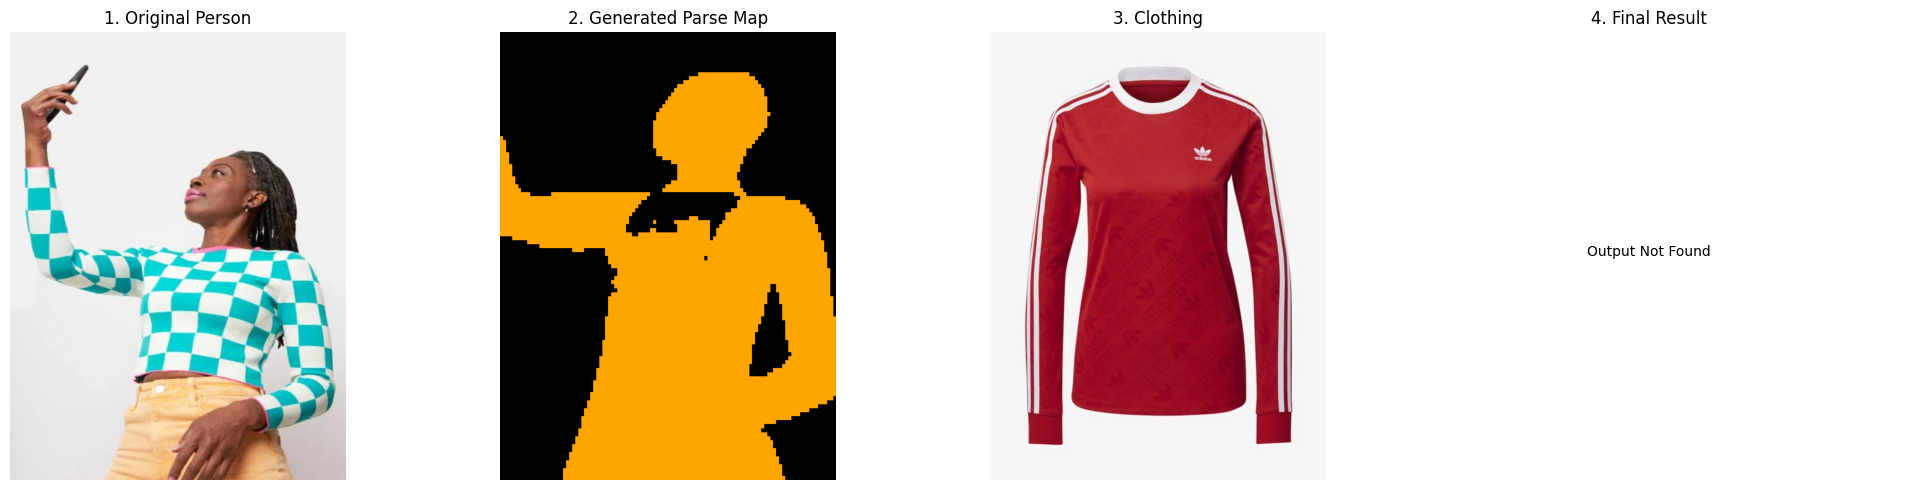

In [19]:
# ===================================================================
# Part 0: Configuration
# ===================================================================
import os
import shutil
import cv2
import numpy as np
import json
import torch
from PIL import Image
import sys
import matplotlib.pyplot as plt

# --- ✍️ User Configuration ---
PERSON_IMAGE_PATH = "/kaggle/input/taher-image/cloth_try_on_image.webp"
CLOTH_IMAGE_NAME = "00008_00.jpg"
# --- End Configuration ---

# ===================================================================
# Part 1: Full Environment Setup
# ===================================================================
print("## PART 1: SETTING UP THE ENVIRONMENT ##")
print("🧹 Cleaning up previous runs for a fresh start...")
os.chdir("/kaggle/working/")
os.system("rm -rf VITON-HD pytorch-openpose detectron2 model_final_162be9.pkl")

print("🚀 Cloning all necessary repositories...")
os.system("git clone https://github.com/shadow2496/VITON-HD.git > /dev/null 2>&1")
os.system("git clone https://github.com/Hzzone/pytorch-openpose.git > /dev/null 2>&1")
os.system("git clone https://github.com/facebookresearch/detectron2.git > /dev/null 2>&1")

print("📦 Installing all dependencies...")
os.system("pip install -q av")
os.system("pip install -e /kaggle/working/detectron2 > /dev/null")
os.system("pip install -q -r /kaggle/working/pytorch-openpose/requirements.txt")
os.system("pip install -q torchgeometry scikit-image")
print("✅ Setup complete.")

# ===================================================================
# Part 2: Prepare Input Images & Directories
# ===================================================================
print("\n## PART 2: PREPARING INPUT IMAGES ##")
VITON_HD_DIR = "/kaggle/working/VITON-HD"
DATASET_DIR = os.path.join(VITON_HD_DIR, "datasets")
HD_VTON_TEST_DIR = os.path.join(DATASET_DIR, "test")
ANNA_WINTOUR_DATASET_PATH = "/kaggle/input/anna-wintour/clothes_tryon_dataset"

for folder in ["cloth", "cloth-mask", "image", "image-parse-v3", "openpose_img", "openpose_json"]:
    os.makedirs(os.path.join(HD_VTON_TEST_DIR, folder), exist_ok=True)

TARGET_PERSON_NAME = "person_01.jpg"
TARGET_CLOTH_NAME = "cloth_01.jpg"
person_image_dest_path = os.path.join(HD_VTON_TEST_DIR, "image", TARGET_PERSON_NAME)

shutil.copy(PERSON_IMAGE_PATH, person_image_dest_path)
shutil.copy(os.path.join(ANNA_WINTOUR_DATASET_PATH, "test/cloth", CLOTH_IMAGE_NAME), os.path.join(HD_VTON_TEST_DIR, "cloth", TARGET_CLOTH_NAME))
shutil.copy(os.path.join(ANNA_WINTOUR_DATASET_PATH, "test/cloth-mask", CLOTH_IMAGE_NAME), os.path.join(HD_VTON_TEST_DIR, "cloth-mask", TARGET_CLOTH_NAME))
print(" -> Original files copied.")

print(" -> Resizing person image to 1024x768...")
img = cv2.imread(person_image_dest_path)
img_resized = cv2.resize(img, (768, 1024), interpolation=cv2.INTER_AREA)
cv2.imwrite(person_image_dest_path, img_resized)
print("✅ Image preparation complete.")

# ===================================================================
# Part 3: Generate OpenPose Files
# ===================================================================
print("\n## PART 3: GENERATING OPENPOSE FILES ##")
OPENPOSE_DIR = "/kaggle/working/pytorch-openpose"
shutil.copytree("/kaggle/input/openpose-pytorch/pytorch-openpose/model", os.path.join(OPENPOSE_DIR, "model"), dirs_exist_ok=True)
os.chdir(OPENPOSE_DIR)

from src.body import Body
from src import util

body_estimation = Body('model/body_pose_model.pth')
oriImg = cv2.imread(person_image_dest_path)
candidate, subset = body_estimation(oriImg)

canvas = np.zeros_like(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)
output_image_path = os.path.join(HD_VTON_TEST_DIR, "openpose_img", TARGET_PERSON_NAME.replace('.jpg', '_rendered.png'))
cv2.imwrite(output_image_path, canvas)
print(" -> Rendered pose image saved.")

people_list = [{'pose_keypoints_2d': []}]
for i in range(18):
    for n in range(len(subset)):
        index = int(subset[n][i])
        if index == -1: people_list[0]['pose_keypoints_2d'].extend([0, 0, 0]); continue
        x, y = candidate[index][0:2]
        people_list[0]['pose_keypoints_2d'].extend([x, y, candidate[index][2]])
output_json_path = os.path.join(HD_VTON_TEST_DIR, "openpose_json", TARGET_PERSON_NAME.replace('.jpg', '_keypoints.json'))
with open(output_json_path, 'w') as f: json.dump({'people': people_list}, f)
print(" -> OpenPose JSON saved.")
print("✅ OpenPose generation complete.")

# ===================================================================
# Part 4: Generate High-Quality 2D Parse Image with DensePose
# ===================================================================
os.chdir("/kaggle/working/")
print("\n## PART 4: GENERATING 2D PARSE IMAGE ##")
sys.path.insert(0, '/kaggle/working/detectron2')
sys.path.insert(0, '/kaggle/working/detectron2/projects/DensePose')

print(" -> Downloading DensePose model...")
os.system("wget -q https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl -P /kaggle/working/")

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from densepose import add_densepose_config

print(" -> Running DensePose inference...")
cfg = get_cfg()
add_densepose_config(cfg)
cfg.merge_from_file("/kaggle/working/detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.WEIGHTS = "/kaggle/working/model_final_162be9.pkl"
predictor = DefaultPredictor(cfg)

with torch.no_grad(): outputs = predictor(oriImg)["instances"]

densepose_output_tensor = outputs.pred_densepose.coarse_segm[0]
densepose_map_tensor = torch.argmax(densepose_output_tensor, dim=0)
densepose_map = densepose_map_tensor.to("cpu").numpy().astype(np.uint8)

print(" -> Converting DensePose output to VTON-HD format...")
final_parsing_map = np.zeros_like(densepose_map, dtype=np.uint8)
final_parsing_map[np.isin(densepose_map, [1, 2])] = 4
final_parsing_map[np.isin(densepose_map, [3, 4, 7, 8, 9, 10])] = 6
final_parsing_map[np.isin(densepose_map, [6, 12])] = 15
final_parsing_map[np.isin(densepose_map, [5, 11])] = 14
final_parsing_map[np.isin(densepose_map, [23, 24])] = 11

# --- THIS IS THE FIX ---
# Explicitly resize the final map to the required 1024x768 dimensions before saving
final_parsing_map_resized = cv2.resize(final_parsing_map, (768, 1024), interpolation=cv2.INTER_NEAREST)
# --- END FIX ---

output_parse_path = os.path.join(HD_VTON_TEST_DIR, "image-parse-v3", TARGET_PERSON_NAME.replace('.jpg', '.png'))
Image.fromarray(final_parsing_map_resized).save(output_parse_path)
print(f" -> Final detailed `image-parse.png` saved successfully.")
print("✅ Segmentation map generation complete.")

# ===================================================================
# Part 5: Run VTON Inference & Display Result
# ===================================================================
print("\n## PART 5: RUNNING VIRTUAL TRY-ON ##")
os.chdir(VITON_HD_DIR)
print(" -> Patching HD-VTON script for folder names...")
file_path = "datasets.py"
with open(file_path, 'r') as f: content = f.read()
content = content.replace("'openpose-img'", "'openpose_img'")
content = content.replace("'openpose-json'", "'openpose_json'")
content = content.replace("'image-parse'", "'image-parse-v3'")
with open(file_path, 'w') as f: f.write(content)
print(" -> Script patched.")

with open("./datasets/test_pairs.txt", "w") as f: f.write(f"{TARGET_PERSON_NAME} {TARGET_CLOTH_NAME}")
print(" -> Created test pairs file.")

CHECKPOINT_SOURCE_PATH = "/kaggle/input/checkpoints/checkpoints"
print("\n▶️ Starting Virtual Try-On... (This may take a few minutes)")
os.system(f"""
python test.py \
    --name "custom_vton_run" \
    --dataset_dir ./datasets \
    --checkpoint_dir "{CHECKPOINT_SOURCE_PATH}" \
    --dataset_list "test_pairs.txt" \
    --workers 0
""")

print("\n🎉 Process finished!")

# --- Display Final Results and Intermediate Files for Debugging ---
print("\n🖼️ Displaying results for verification...")

label_to_color = {
    11: [0, 0, 255], 4: [255, 165, 0], 14: [0, 255, 0],
    15: [0, 255, 255], 6: [255, 0, 255],
}
# Colorize the map we just created for easy viewing
color_segmentation_map = np.zeros((final_parsing_map_resized.shape[0], final_parsing_map_resized.shape[1], 3), dtype=np.uint8)
for label_id, color in label_to_color.items():
    color_segmentation_map[final_parsing_map_resized == label_id] = color

person_path = os.path.join(DATASET_DIR, "test/image", TARGET_PERSON_NAME)
cloth_path = os.path.join(DATASET_DIR, "test/cloth", TARGET_CLOTH_NAME)
output_filename = f"{TARGET_PERSON_NAME.replace('.jpg', '')}_{TARGET_CLOTH_NAME.replace('.jpg', '')}.jpg"
output_path = os.path.join("/kaggle/working/VITON-HD/results/custom_vton_run/test/images/", output_filename)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(Image.open(person_path)); axes[0].set_title('1. Original Person'); axes[0].axis('off')
axes[1].imshow(color_segmentation_map); axes[1].set_title('2. Generated Parse Map'); axes[1].axis('off')
axes[2].imshow(Image.open(cloth_path)); axes[2].set_title('3. Clothing'); axes[2].axis('off')

if not os.path.exists(output_path):
    axes[3].text(0.5, 0.5, 'Output Not Found', ha='center'); axes[3].set_title('4. Final Result'); axes[3].axis('off')
else:
    axes[3].imshow(Image.open(output_path)); axes[3].set_title('4. Final Result'); axes[3].axis('off')

plt.tight_layout()
plt.show()